In [1]:
! nvidia-smi

Fri Apr 29 01:05:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:

import tensorflow as tf
from tensorflow.keras.layers import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import IPython

In [3]:
data_dir = '../input/flickr-image-dataset/flickr30k_images'
image_dir = f'{data_dir}/flickr30k_images'
csv_file = f'{data_dir}/results.csv'

df = pd.read_csv(csv_file, delimiter='|')

print(f'[INFO] The shape of dataframe: {df.shape}')
print(f'[INFO] The columns in the dataframe: {df.columns}')
print(f'[INFO] Unique image names: {len(pd.unique(df["image_name"]))}')




[INFO] The shape of dataframe: (158915, 3)
[INFO] The columns in the dataframe: Index(['image_name', ' comment_number', ' comment'], dtype='object')
[INFO] Unique image names: 31783


A quick observation here is to see that the dataframe has `158915` elements but only `31783` image names. This means that there is a duplicacy involved. On further inspection we will see that each image has 5 unique captions attached to it ($31783\times 5=158915$)

While looking into the dataframe I found out that `19999` had some messed up entries. This has led me to manually change the entries in that row.

In [4]:
df.columns = ['image_name', 'comment_number', 'comment']
del df['comment_number']

# Under scrutiny I had found that 19999 had a messed up entry
df['comment'][19999] = ' A dog runs across the grass .'

# Image names now correspond to the absolute position
df['image_name'] = image_dir+'/'+df['image_name']

# <start> comment <end>
df['comment'] = "<start> "+df['comment']+" <end>"

In [5]:
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
SIZE = len(df)

train_size = int(0.7* SIZE) 
val_size = int(0.1* SIZE)
test_size = int(0.2* SIZE)

train_size, val_size, test_size

train_df = df.iloc[:train_size,:]
val_df = df.iloc[train_size+1:train_size+val_size,:]
test_df = df.iloc[train_size+val_size+1:,:]

Splitting the dataframe accordingly

<start>  A young man with darker skin and a shaved head is sitting down smoking a cigarette . <end>


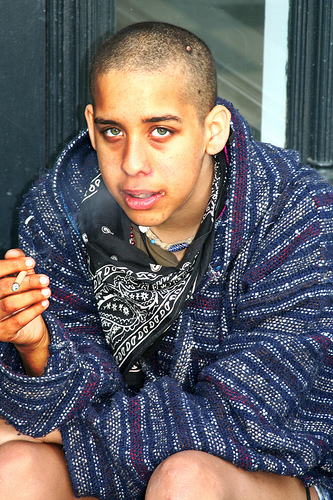

In [6]:
# Enter different indices.
index = 200

image_name = train_df['image_name'][index]
comment = train_df['comment'][index]

print(comment)

IPython.display.Image(filename=image_name)

In [7]:
# Choose the top 5000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

# build the vocabulary
tokenizer.fit_on_texts(train_df['comment'])

In [8]:
# This is a sanity check function
def check_vocab(word):
    i = tokenizer.word_index[word]
    print(f"The index of the word: {i}")
    print(f"Index {i} is word {tokenizer.index_word[i]}")
    
check_vocab("pajama")

The index of the word: 4030
Index 4030 is word pajama


Here we are padding the sentences so that each of the sentences are of the same length.

In [9]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_df['comment'])
val_seqs = tokenizer.texts_to_sequences(val_df['comment'])
test_seqs = tokenizer.texts_to_sequences(test_df['comment'])

# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
train_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
val_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')
test_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

In [10]:
train_cap_ds = tf.data.Dataset.from_tensor_slices(train_cap_vector)
val_cap_ds = tf.data.Dataset.from_tensor_slices(val_cap_vector)
test_cap_ds = tf.data.Dataset.from_tensor_slices(test_cap_vector)

2022-04-29 01:06:01.382757: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 01:06:01.499132: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 01:06:01.500056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 01:06:01.502633: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
@tf.function
def load_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))
    return img

train_img_name = train_df['image_name'].values
val_img_name = val_df['image_name'].values
test_img_name = test_df['image_name'].values

train_img_ds = tf.data.Dataset.from_tensor_slices(train_img_name).map(load_img)
val_img_ds = tf.data.Dataset.from_tensor_slices(val_img_name).map(load_img)
test_img_ds = tf.data.Dataset.from_tensor_slices(test_img_name).map(load_img)

# Joint data

In [12]:
# prefecth and batch the dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 512

train_ds = tf.data.Dataset.zip((train_img_ds, train_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.zip((val_img_ds, val_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
test_ds = tf.data.Dataset.zip((test_img_ds, test_cap_ds)).shuffle(42).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

Sanity check for the division of datasets

In [13]:
# Some global variables
EMBEDDIN_DIM = 512
VOCAB_SIZE = 10000
UNITS_RNN = 256

In [14]:
class CNN_Encoder(tf.keras.Model):
    
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.embedding_dim = embedding_dim
        
    def build(self, input_shape):
        self.resnet = tf.keras.applications.ResNet50(include_top=False,
                                                     weights='imagenet')
        self.resnet.trainable=False
        self.gap = GlobalAveragePooling2D()
        self.fc = Dense(units=self.embedding_dim,
                        activation='sigmoid')
        
    def call(self, x):
        x = self.resnet(x)
        x = self.gap(x)
        x = self.fc(x)
        return x

    # Checking the CNN
encoder = CNN_Encoder(EMBEDDIN_DIM)


In [15]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.embedding = Embedding(input_dim=self.vocab_size,
                                   output_dim=self.embedding_dim)
    
    def build(self, input_shape):
        self.gru1 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.gru2 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.gru3 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.gru4 = GRU(units=self.units,
                       return_sequences=True,
                       return_state=True)
        self.fc1 = Dense(self.units)
        self.fc2 = Dense(self.vocab_size)

    def call(self, x, initial_zero=False):
        # x, (batch, 512)
        # hidden, (batch, 256)
        if initial_zero:
            initial_state = decoder.reset_state(batch_size=x.shape[0])
            output, state = self.gru1(inputs=x,
                                      initial_state=initial_state)
            output, state = self.gru2(inputs=output,
                                      initial_state=initial_state)
            output, state = self.gru3(inputs=output,
                                      initial_state=initial_state)
            output, state = self.gru4(inputs=output,
                                      initial_state=initial_state)
        else:
            output, state = self.gru1(inputs=x)
            output, state = self.gru2(inputs=output)
            output, state = self.gru3(inputs=o`utput)
            output, state = self.gru4(inputs=output)
        # output, (batch, 256)
        x = self.fc1(output)
        x = self.fc2(x)
        
        return x, state
    
    def embed(self, x):
        return self.embedding(x)
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [16]:
# Checking the RNN
decoder = RNN_Decoder(embedding_dim=EMBEDDIN_DIM,
                      units=UNITS_RNN,
                      vocab_size=VOCAB_SIZE)
for image, caption in train_ds.take(1):
    features = tf.expand_dims(encoder(image),1) # (batch, 1, 128)
    em_words = decoder.embed(caption)
    x = tf.concat([features,em_words],axis=1)
    print(x.shape)
    predictions, state = decoder(x, True)
    print(predictions.shape)
    print(state.shape)

2022-04-29 01:06:12.246391: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


94781440/94765736 [==============================] - 1s 0us/step


2022-04-29 01:06:19.612141: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


(512, 81, 512)
(512, 81, 10000)
(512, 256)


In [17]:
encoder = CNN_Encoder(EMBEDDIN_DIM)
decoder = RNN_Decoder(embedding_dim=EMBEDDIN_DIM,
                      units=UNITS_RNN,
                      vocab_size=VOCAB_SIZE)

We use `Adam` as the optimizer.

The loss is `SparseCategoricalCrossentropy`, because here it would be inefficient to use one-hot-encoders are the ground truth. We will also use mask to help mask the `<pad>` so that we do not let the sequence model learn to overfit on the same.

In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [19]:
@tf.function
def train_step(img_tensor, target):
    # img_tensor (batch, 224,224,3)
    # target     (batch, 80)
    loss = 0
    with tf.GradientTape() as tape:
        features = tf.expand_dims(encoder(img_tensor),1) # (batch, 1, 128)
        em_words = decoder.embed(target)
        x = tf.concat([features,em_words],axis=1)
        predictions, _ = decoder(x, True)

        loss = loss_function(target[:,1:], predictions[:,1:-1,:])

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss

In [20]:
@tf.function
def val_step(img_tensor, target):
    # img_tensor (batch, 224,224,3)
    # target     (batch, 80)
    loss = 0
    features = tf.expand_dims(encoder(img_tensor),1) # (batch, 1, 128)
    em_words = decoder.embed(target)
    x = tf.concat([features,em_words],axis=1)
    predictions, _ = decoder(x, True)
    loss = loss_function(target[:,1:], predictions[:,1:-1,:])
    
    loss = train_step(img_tensor, target)
    return loss

In [21]:

EPOCHS = 10
epoch_wise_loss = []
epoch_wise_val_loss = []
for epoch in range(EPOCHS):
    batch_wise_loss = []
    for (batch, (img_tensor, target)) in enumerate(train_ds):
        loss = train_step(img_tensor, target)
        batch_wise_loss.append(loss.numpy())
        if batch%100 == 0:
            print(f'Epoch: {epoch} Batch: {batch} Loss: {batch_wise_loss[-1]:.3f}')
   
    epoch_wise_loss.append(np.mean(batch_wise_loss))

    batch_wise_val_loss = []
    for (batch, (img_tensor, target)) in enumerate(val_ds):
        loss = val_step(img_tensor, target)
        batch_wise_val_loss.append(loss.numpy())
    epoch_wise_val_loss.append(np.mean(batch_wise_val_loss))
    print(f'Epoch: {epoch} Total Loss: {epoch_wise_loss[-1]:.3f} Val Loss:{epoch_wise_val_loss[-1]:.3f}')
    print('-'*40)

Epoch: 0 Batch: 0 Loss: 1.556
Epoch: 0 Batch: 100 Loss: 0.923
Epoch: 0 Batch: 200 Loss: 0.871
Epoch: 0 Total Loss: 0.938 Val Loss:0.952
----------------------------------------
Epoch: 1 Batch: 0 Loss: 0.894
Epoch: 1 Batch: 100 Loss: 0.890
Epoch: 1 Batch: 200 Loss: 0.825
Epoch: 1 Total Loss: 0.877 Val Loss:0.855
----------------------------------------
Epoch: 2 Batch: 0 Loss: 0.797
Epoch: 2 Batch: 100 Loss: 0.764
Epoch: 2 Batch: 200 Loss: 0.735
Epoch: 2 Total Loss: 0.762 Val Loss:0.790
----------------------------------------
Epoch: 3 Batch: 0 Loss: 0.761
Epoch: 3 Batch: 100 Loss: 0.728
Epoch: 3 Batch: 200 Loss: 0.685
Epoch: 3 Total Loss: 0.715 Val Loss:0.749
----------------------------------------
Epoch: 4 Batch: 0 Loss: 0.709
Epoch: 4 Batch: 100 Loss: 0.675
Epoch: 4 Batch: 200 Loss: 0.664
Epoch: 4 Total Loss: 0.674 Val Loss:0.705
----------------------------------------
Epoch: 5 Batch: 0 Loss: 0.673
Epoch: 5 Batch: 100 Loss: 0.651
Epoch: 5 Batch: 200 Loss: 0.635
Epoch: 5 Total Loss: 

In [22]:
epoch_wise_loss

[0.9379426,
 0.87652314,
 0.7618758,
 0.71481645,
 0.67447823,
 0.64813954,
 0.62876076,
 0.61195934,
 0.5965646,
 0.5832211]

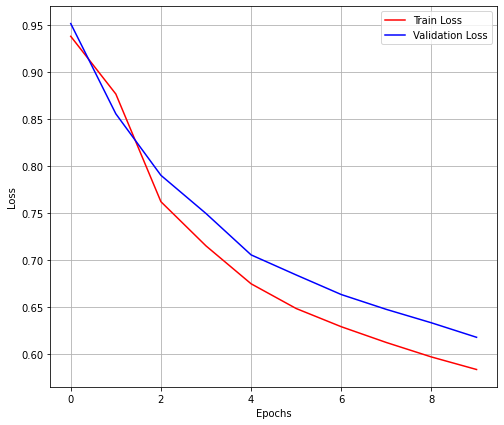

In [23]:
import matplotlib.pyplot as plt
epochs = 10
fig, ax = plt.subplots(figsize=(8,7))
plt.plot(range(epochs), epoch_wise_loss , color='r')
plt.plot(range(epochs), epoch_wise_val_loss, color='b')
plt.legend(["Train Loss", "Validation Loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
ax.grid(True)

Save the weights

In [24]:
from matplotlib import pyplot as plt

plt.savefig('foo.png')

<Figure size 432x288 with 0 Axes>

In [25]:
!mkdir models
encoder.save_weights('./models/encoder.h5')
decoder.save_weights('./models/decoder.h5')

# Inference
## Total Loss

In [26]:
encoder = CNN_Encoder(EMBEDDIN_DIM)
for image, caption in train_ds.take(1):
    encoder(image)

decoder = RNN_Decoder(embedding_dim=EMBEDDIN_DIM,
                      units=UNITS_RNN,
                      vocab_size=VOCAB_SIZE)
for image, caption in train_ds.take(1):
    features = tf.expand_dims(encoder(image),1)
    em_words = decoder.embed(caption)
    x = tf.concat([features,em_words],axis=1)
    predictions, state = decoder(x, True)

encoder.load_weights('./models/encoder.h5')
decoder.load_weights('./models/decoder.h5')

# **Here i will take my model and predict captions for all the images in the test set and store it in a csv. This CSV File will be used by the script 'text-nearest-images.ipyn'**

In [27]:
data = []
for img, cap in test_ds.take(1):
   
    img = tf.expand_dims(img[0],0)
    cap = tf.expand_dims(cap[0],0)

    feature = tf.expand_dims(encoder(img),1) # (1, 1, 128)
    prediction, _ = decoder(feature, True)

    word = tf.reshape(tokenizer.word_index['<start>'], shape=(1,1))
    em_words = decoder.embed(word)

    prediction, _ = decoder(em_words)
    idx = tf.random.categorical(tf.squeeze(prediction,1), 1)[0][0].numpy()
    word = tokenizer.index_word[idx]

    count = 0
    catption = ''
    while word != '<end>':
        print(word, end=" ")
        caption += word
        word_int = tf.reshape(tokenizer.word_index[word], shape=(1,1))  
        em_words = decoder.embed(word_int)
        prediction, _ = decoder(em_words)
        idx = tf.random.categorical(tf.squeeze(prediction,1), 1)[0][0].numpy()
        word = tokenizer.index_word[idx]
    
    data.append(img, caption)
        
df_test = pd.DataFrame(data)
print("test DF Created with captions")

test DF Created with captions


In [28]:
df_test.to_csv('df_test_caption.csv')